In [1]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import time 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
import os
import time
from imagePreprocess import getImagesVarAndMean

In [2]:
isDataset2 = False
continueTrain = True
dataDir = "data/stl10/" if isDataset2 else "data/resized/"
biggerNet = True
depthMultiplier = 2
initializer = 'he_normal'#'glorot_uniform'
activation = 'relu'#LeakyReLU(alpha=0.3)
finalActivation = 'relu' # 'sigmoid'
normalize = finalActivation == 'sigmoid' # normalizing output hinders this training
colorspace = ['lab','rgb','hsv'][0]
rgb = colorspace == 'rgb'
lab = colorspace == 'lab'
trainSplitPercent = 0.8 # 0.8
valSplitPercent = 0.02 # 0.02

data_IDs = os.listdir(dataDir)
print('dataset size',len(data_IDs))
trainSize = int(len(data_IDs)*trainSplitPercent)

dataset size 202599


In [3]:
def showHsv(img):    
    if rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif lab:
        img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    plt.imshow(img)
    plt.show()

def customLoss(yTrue, yPred):
    # cyclic loss
    hueTrue = yTrue[...,0]
    huePred = yPred[...,0]
    maxHue = 180
#     hue = K.square(huePred - hueTrue) 
    
    hue2 = K.minimum(K.square(huePred - hueTrue), 
                    K.minimum(K.square(huePred - hueTrue + maxHue), 
                              K.square(huePred - hueTrue - maxHue)))
    #hue = K.minimum((huePred + 181 - hueTrue) % 181, (hueTrue + 181 - huePred) % 181) #3
    #hue = K.square( (huePred - hueTrue) % 181 )
    satDiff = yPred[...,1] - yTrue[...,1]
    # double loss for undershooting saturation
    # if sign is + then mul is 2, if sign is - mul is 2
    mul1or2 = (-K.sign(satDiff) +1)*2 + 1 # was /2
    saturation =  mul1or2*K.square(satDiff)
    #saturation = K.square(satDiff)
    #hue = hue  + 1 / (huePred + 1)
    #hue2 = hue2  + 1 / (huePred + 1)
    return K.concatenate([hue2, saturation], axis=-1) # predictedHue was 0 when order is reversed

def saturationLoss(yTrue, yPred):
    multiplier = 1 / K.sqrt(K.abs( (yPred[...,0] - 128) * (yPred[...,1] - 128)) +0.1)
    a =  K.square(yTrue[...,0] - yPred[...,0]) 
    b =  K.square(yTrue[...,1] - yPred[...,1]) 
    return K.concatenate([a*multiplier, b*multiplier], axis=-1)
    
def mapOutOfGreen(m):
    '''maps green colors into others'''
    minGreen, maxGreen = 42, 63
    target = 160
    r = np.copy(m)
    r[(r >= minGreen) & (r<=maxGreen)] = (r[(r >= minGreen) & (r<=maxGreen)] - minGreen) +  target
    # smoother transition
    d = 7
    lower = minGreen - d
    sel = r[(r < minGreen) & (r>= lower)]
    r[(r < minGreen) & (r>= lower)] = (sel - lower) /d * (target - lower) + sel

    higher = maxGreen + d
    sel = r[(r > maxGreen) & (r<= higher)]
    r[(r > maxGreen) & (r<= higher)] = (sel - higher) /d * (target - higher) + sel
    return r

def showImgFromPredict(hs, v, showDetails=False):
    '''shows h/s/v and complete image
    hs- a list containing hue and saturation matrices
    v - value matrix.
    all three should be uint8
    '''
    if rgb:
        RGB, v = hs[0], v[0,...,0]
        print('rgb.shape',RGB.shape)
        img = cv2.cvtColor(RGB, cv2.COLOR_BGR2RGB)
    else:
        hs, v = hs[0], v[0,...,0]
        #print('hs:',hs.shape)
        h, s = hs[...,0], hs[...,1]
        #h = mapOutOfGreen(h)
        #print('h',h.shape,'s',s.shape,'v',v.shape)
        #print(h.dtype, s.dtype, v.dtype)
        hsv = cv2.merge([v,h,s] if lab else [h,s,v] )
        img = cv2.cvtColor(hsv, cv2.COLOR_LAB2RGB if lab else cv2.COLOR_HSV2RGB)
    if not showDetails:
        plt.imshow(img)
        plt.show()
        return
        
    f, axarr = plt.subplots(1,4 + 1*rgb, figsize=(15,15))
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].imshow(img)
    titles = ['blue', 'green', 'red','value'] if rgb else ['A','B','L'] if lab else ['hue', 'saturation', 'value']
    for i in range(3 if rgb else 2,-1,-1):
        if rgb:
            pic = RGB[:,:,i] if i < 3 else v
        elif lab:
            pic = hsv[:,:,-i-1]
        else:
            pic = hsv[:,:,i]
        axarr[1+i].title.set_text(titles[i])
        axarr[1+i].set_xticks([])
        axarr[1+i].set_yticks([])
        axarr[1+i].imshow(pic, cmap='gray')
    plt.show()
    
def predictFromImage(img, showDetails=False):
    '''processes input img, makes prediction from its value,
    and shows resulting image, hue, saturation and value'''
    inX, inY = loadImg(img )
    inX, inY = inX[None,...,None], inY[None,:]

    X, Y = inX, inY
    # 1st layer is hue, 2nd saturation
    predY = model.predict(X)
    if not rgb:
        print('predy',predY.min(), predY.max(), predY.mean() ,predY.shape)
        print(f'{"A" if lab else "hue"}:', predY[...,0].min(), predY[...,0].max(), predY[...,0].mean() )
        print(f'{"B" if lab else "sat"}:', predY[...,1].min(), predY[...,1].max(), predY[...,1].mean() )
    else:
        print('predy',predY.min(), predY.max(), predY.mean() ,predY.shape)
        print('red:',predY[...,2].min(), predY[...,2].max(), predY[...,2].mean() )
        print('green:',predY[...,1].min(), predY[...,1].max(), predY[...,1].mean() )
        print('blue:',predY[...,0].min(), predY[...,0].max(), predY[...,0].mean() )
    if normalize:
        # hue and sat [0,1] -> their range
        predY[...,0] *= 180
        predY[...,1] *= 255
    else:
        if not rgb:
            predY[...,0] = predY[...,0] % 181
        else:
            predY = np.minimum(predY, 255)
        predY = np.maximum(predY, 0)
    X = X.astype('uint8')
    predY = predY.astype('uint8')
    print('predy uint8',predY.min(), predY.max(), predY.mean() )
    if not rgb:
        hue = predY[...,0]
        print(f'{"A" if lab else "hue"} uint8', hue.min(), hue.max(), hue.mean() )

    showImgFromPredict(predY, X, showDetails)
    
def predictions(start=trainSize+98, count=10):
    '''display count predictionst, beginning from start'''
    for i in range(start,start+count):
        fname = f'data/stl10/unlabeled_image_png_{i}.png' if isDataset2 else f'data/resized/{i:06}.jpg'
        predictFromImage(fname, True) 

OpenCV uses H: 0 - 180, S: 0 - 255, V: 0 - 255
(1008, 1600, 3)
LAB:
In CV2 for 8bit images, the range of all 3 channels is [0-255]
It has the following properties.

Perceptually uniform color space which approximates how we perceive color.
Independent of device ( capturing or displaying ).
Used extensively in Adobe Photoshop.
Is related to the RGB color space by a complex transformation equation.
image with its value untouched, but saturation and hue randomized:


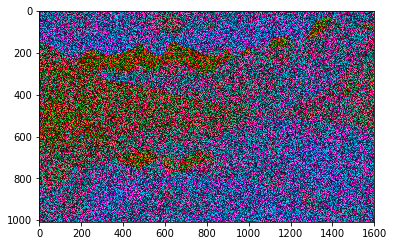

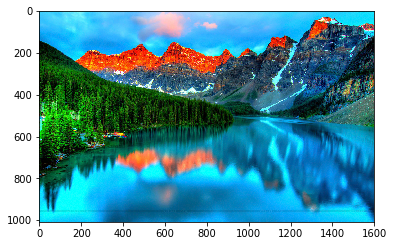

In [4]:
print("OpenCV uses H: 0 - 180, S: 0 - 255, V: 0 - 255")
img_in = cv2.imread('pic.jpg')
hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2LAB if lab else cv2.COLOR_BGR2HSV)
print(hsv.shape)
print('''LAB:
In CV2 for 8bit images, the range of all 3 channels is [0-255]
It has the following properties.

Perceptually uniform color space which approximates how we perceive color.
Independent of device ( capturing or displaying ).
Used extensively in Adobe Photoshop.
Is related to the RGB color space by a complex transformation equation.''')
h,s,v = cv2.split(hsv)
#print('s',s.shape)
s = (np.random.random(s.shape) * 255).astype('uint8')
h = (np.random.random(s.shape) * 180).astype('uint8')
#s = np.maximum(0, v)
#print(s)
hsv2 = cv2.merge([h,s,v])
print('image with its value untouched, but saturation and hue randomized:'); showHsv(hsv2); showHsv(hsv)

In [5]:
def loadImg(path):
    '''
    returns X - value
            Y - (hue, saturation) or (blue, green, red) or (L, A, B)
    '''
    img_in = cv2.imread(path)
    if lab:
        LAB = cv2.cvtColor(img_in, cv2.COLOR_BGR2LAB)
        l,a,b = cv2.split(LAB)
        return l, np.dstack((a,b))
        
    hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    X = v
    if rgb:
        b,g,r = cv2.split(img_in)
        Y = np.dstack((b,g,r))
    else:
        Y = np.dstack((h,s))
    #print("loadX.shape", X.shape, 'loadY.shape', Y.shape)
    return X, Y

# celebA dataset from https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg
# 202,599 images of size 178x218
# in /resized/ they are cropped to be 128x128

# stl10 dataset from https://www.kaggle.com/jessicali9530/stl10
# 100,000 images of size 96x96

# data generator for feeding into memory parts of dataset
class DataGenerator(tf.keras.utils.Sequence):
    'data generator for feeding into memory parts of dataset'
    def __init__(self, list_IDs, dim, batch_size=32, in_channels=1,
                 out_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.shuffle = shuffle
        self.on_epoch_end()
#         self.hsstd = np.sqrt(var[...,:2])
#         self.hsmean = mean[...,:2]
#         self.vstd = np.sqrt(var[...,2])
#         self.vmean = mean[...,2]

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(list_IDs_temp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        # target 2 channels
        Y = np.empty((self.batch_size, *self.dim, self.out_channels))
        # print(X.shape, Y.shape)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i], Y[i] = loadImg(dataDir + ID)
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        #X = (X - self.vmean)/self.vstd # it doesn't like standardization 
        X = np.expand_dims(X, axis=len(X.shape))
        if normalize:
            Y[...,0] /= 180 # was [0] by mistake
            Y[...,1] /= 255
#             X /= 255
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        return X, Y

In [6]:
params = {'dim': (96, 96) if isDataset2 else (128, 128),
          'batch_size': 32,
          'in_channels': 1,
          'out_channels': 3 if rgb else 2,
          'shuffle': True}
train_IDs = data_IDs[:trainSize]
print('train len', len(train_IDs))
valSize = int(len(data_IDs)*valSplitPercent)
splitValAt = int(trainSize + valSize)
val_IDs = data_IDs[trainSize:splitValAt]
print('val len', len(val_IDs))

# params['var'], params['mean'] = getImagesVarAndMean([dataDir + x for x in train_IDs], params['dim'] + (3,))

training_generator = DataGenerator(train_IDs, **params)
validation_generator = DataGenerator(val_IDs, **params)
print(training_generator[0][1].shape)

train len 162079
val len 4051
(32, 128, 128, 2)


In [7]:
def createModel(input_shape, bigger, mul, initializer, activation, finalActivation):
    input_shape = input_shape + (1,)
    inputs = Input(input_shape)
    
    conv1 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(inputs)
    if bigger:
        conv1 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(pool1)
    if bigger:
        conv2 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(pool2)
    if bigger:
        conv3 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(pool3)
    if bigger:
        conv4 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv4)
    
    up5 = Conv2D(64*mul, 2, activation = activation, padding = 'same')(UpSampling2D(size = (2,2))(conv4))
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(merge5)
    if bigger:
        conv5 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv5)
    
    up6 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(merge6)
    if bigger:
        conv6 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv6)
    
    up7 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(merge7)
    conv7 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv7)
    conv7 = Conv2D(4, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv7)
    # Stride 1 deconvolutions — which we often see as the last layer in successful models 
    conv7 = Conv2D(3 if rgb else 2, 1, activation = finalActivation, padding = 'same', kernel_initializer=initializer)(conv7)
    
    model = Model(inputs=inputs, outputs=conv7)
    
    model.compile(loss='mean_squared_error',#customLoss,
                  optimizer=tf.keras.optimizers.Adam(lr=0.001), 
                  metrics=['mae','mse'])
    return model

model = createModel(params['dim'], biggerNet, depthMultiplier, initializer, activation, finalActivation)
model.summary()
print(model.output_shape)

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
____________________________

In [8]:
currTime = time.strftime("%d-%m-%Y-%H-%M-%S", time.localtime())
layers = ['unet', 'bigger' if biggerNet else 'smaller', f'mul{depthMultiplier}', initializer]
NAME = "_".join(str(l) for l in layers) + f"{ currTime }"
print(NAME)
model = createModel(params['dim'], biggerNet, depthMultiplier, initializer, activation, finalActivation)
tensorboard = TensorBoard(log_dir=f'logs/{NAME}')
if continueTrain:
    countEpochs = 1
    model.load_weights('data/lab_fully_trained.h5')
else:
    model.fit_generator(generator=training_generator,
                        validation_data=validation_generator,
                        epochs=1,
                        use_multiprocessing=False,
                        workers=0,
                        callbacks=[tensorboard])
    countEpochs = 1
#Compiling a model does not modify its state. Weights after compilation are the same as before compilation.
# predictions(trainSize, 10)

unet_bigger_mul2_he_normal23-06-2019-13-59-44


In [9]:
# model.load_weights('data/unet_bigger_mul1_glorot_uniform13-05-2019-00-47-35.h5')
# model.save_weights('lab_fully_trained.h5')
# model.load_weights('data/stl.h5')

In [10]:
# best = 100.3095
for i in range(1,1):
    #start_time = time.time()
    hist = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    initial_epoch=countEpochs, # for tensorflow graph continuation
                    epochs=countEpochs+1,
                    use_multiprocessing=False,
                    workers=0,
                    callbacks=[tensorboard])
    countEpochs+=1
    #elapsed_time = time.time() - start_time
    #print(f"epochs:{countEpochs}, elapsed time:{elapsed_time}")
    predictions(trainSize+i, 1)
    last = hist.history['val_loss'][-1]
#     if best < last:
#         break
#     best = last
#     model.save_weights(f'lab_fully_trained{i}.h5')

countEpochs 1
predy 124.96663 155.04292 137.9553 (1, 128, 128, 2)
A: 124.96663 154.50072 136.92345
B: 125.89538 155.04292 138.98715
predy uint8 124 155 137.4556884765625
A uint8 124 154 136.42254638671875


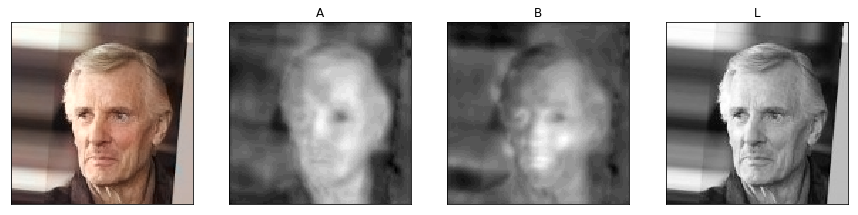

predy 127.026184 162.08167 137.52786 (1, 128, 128, 2)
A: 127.026184 162.08167 136.76021
B: 127.621155 158.5287 138.2955
predy uint8 127 162 137.03228759765625
A uint8 127 162 136.26519775390625


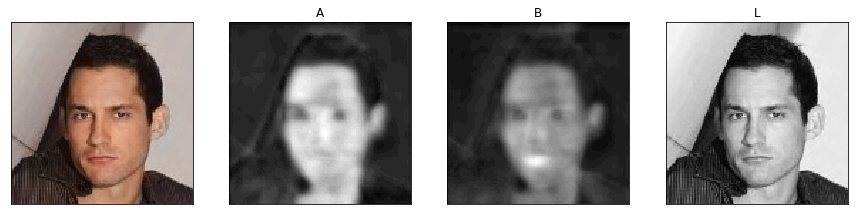

predy 123.89168 155.15356 137.12857 (1, 128, 128, 2)
A: 125.30782 155.15356 136.32104
B: 123.89168 154.59483 137.93608
predy uint8 123 155 136.6246337890625
A uint8 125 155 135.81341552734375


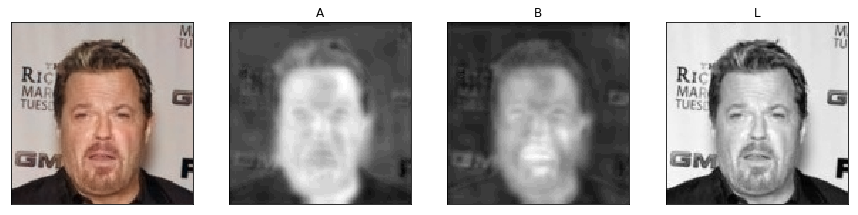

predy 125.61525 157.27087 140.25432 (1, 128, 128, 2)
A: 126.112015 157.27087 138.03917
B: 125.61525 154.0007 142.46948
predy uint8 125 157 139.75314331054688
A uint8 126 157 137.539306640625


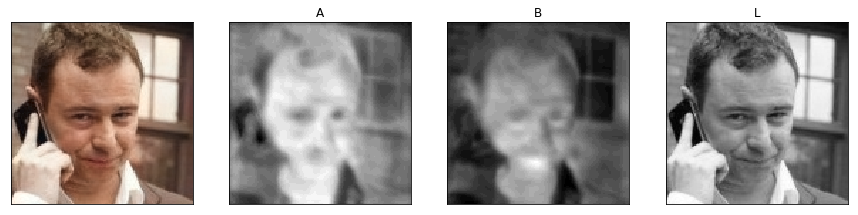

predy 126.00841 153.2406 137.08919 (1, 128, 128, 2)
A: 127.94636 151.6993 136.96594
B: 126.00841 153.2406 137.21243
predy uint8 126 153 136.58966064453125
A uint8 127 151 136.46502685546875


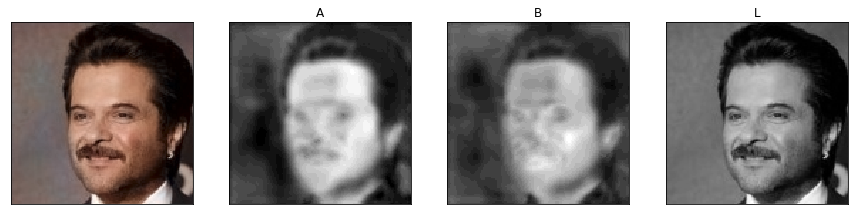

predy 126.02135 154.13138 138.69495 (1, 128, 128, 2)
A: 127.677055 153.95947 137.1389
B: 126.02135 154.13138 140.251
predy uint8 126 154 138.19467163085938
A uint8 127 153 136.6324462890625


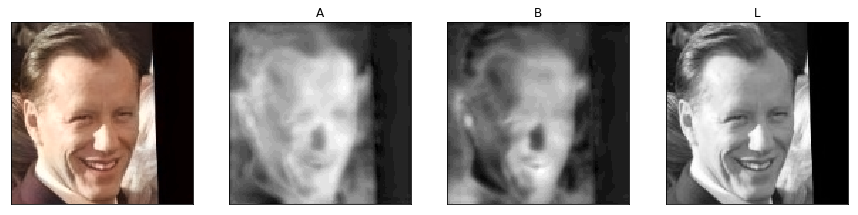

predy 123.90262 160.6742 135.41364 (1, 128, 128, 2)
A: 125.331085 155.82074 134.22385
B: 123.90262 160.6742 136.6034
predy uint8 123 160 134.913330078125
A uint8 125 155 133.7216796875


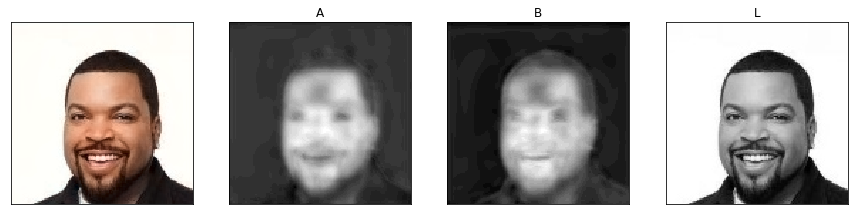

predy 126.44931 157.25508 141.4597 (1, 128, 128, 2)
A: 126.44931 155.57364 138.67836
B: 128.67967 157.25508 144.24101
predy uint8 126 157 140.96115112304688
A uint8 126 155 138.1817626953125


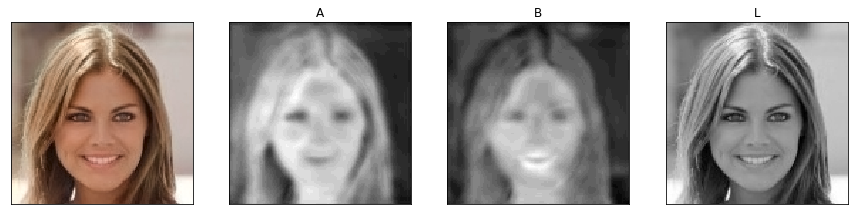

predy 128.41847 153.55017 138.57628 (1, 128, 128, 2)
A: 128.41847 150.41846 137.30219
B: 129.75288 153.55017 139.85037
predy uint8 128 153 138.08016967773438
A uint8 128 150 136.8046875


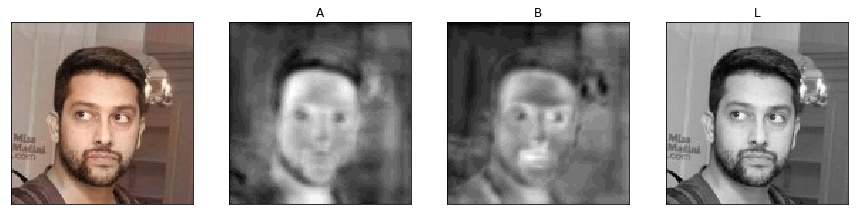

predy 125.93389 167.45615 138.5867 (1, 128, 128, 2)
A: 125.93389 167.45615 136.52512
B: 129.19026 154.70168 140.64828
predy uint8 125 167 138.08935546875
A uint8 125 167 136.02667236328125


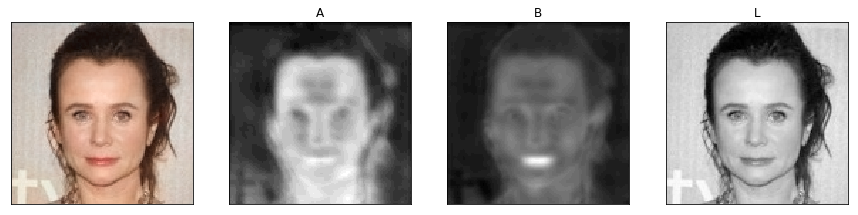

predy 125.465935 162.63258 136.65732 (1, 128, 128, 2)
A: 129.54681 162.63258 136.37253
B: 125.465935 155.21411 136.94212
predy uint8 125 162 136.1568603515625
A uint8 129 162 135.8720703125


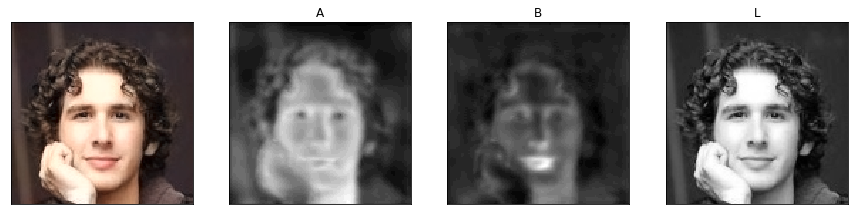

predy 125.14594 175.93973 138.88779 (1, 128, 128, 2)
A: 125.14594 175.93973 135.71469
B: 130.17313 156.59883 142.06088
predy uint8 125 175 138.39230346679688
A uint8 125 175 135.21624755859375


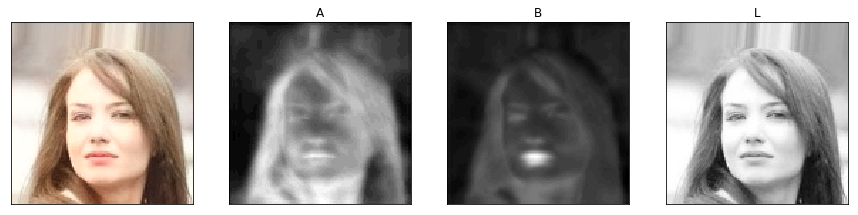

predy 125.07383 155.3377 135.85864 (1, 128, 128, 2)
A: 127.63005 153.7061 136.05005
B: 125.07383 155.3377 135.66724
predy uint8 125 155 135.35183715820312
A uint8 127 153 135.5440673828125


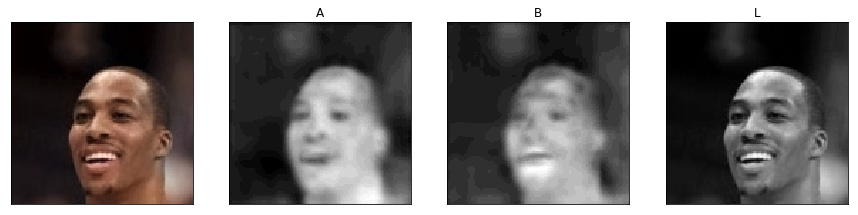

predy 121.22466 164.45914 136.36719 (1, 128, 128, 2)
A: 124.07574 164.45914 134.94394
B: 121.22466 156.05405 137.79044
predy uint8 121 164 135.86886596679688
A uint8 124 164 134.44415283203125


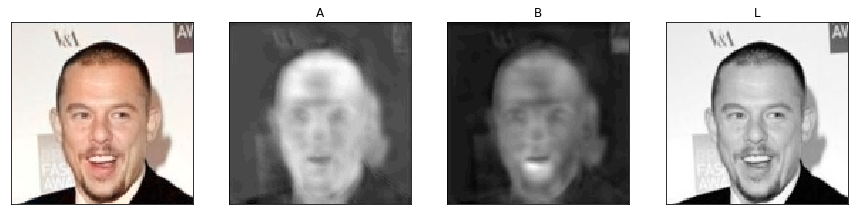

predy 127.34555 155.98488 138.05379 (1, 128, 128, 2)
A: 127.34555 153.0852 136.64694
B: 128.16013 155.98488 139.46063
predy uint8 127 155 137.54977416992188
A uint8 127 153 136.148681640625


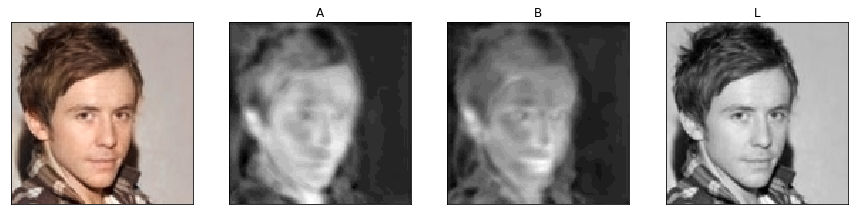

predy 122.15528 153.96638 136.43347 (1, 128, 128, 2)
A: 125.364456 153.17131 137.45135
B: 122.15528 153.96638 135.41562
predy uint8 122 153 135.92977905273438
A uint8 125 153 136.94903564453125


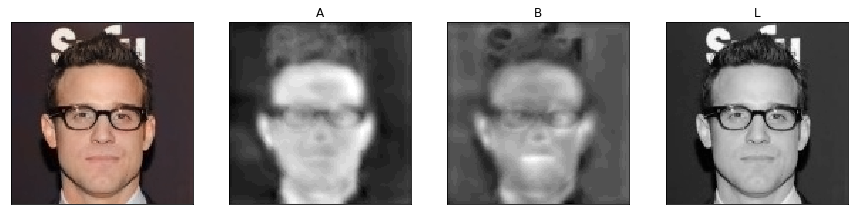

predy 125.90142 156.36375 139.9412 (1, 128, 128, 2)
A: 128.2931 155.94232 138.63489
B: 125.90142 156.36375 141.24747
predy uint8 125 156 139.44613647460938
A uint8 128 155 138.14208984375


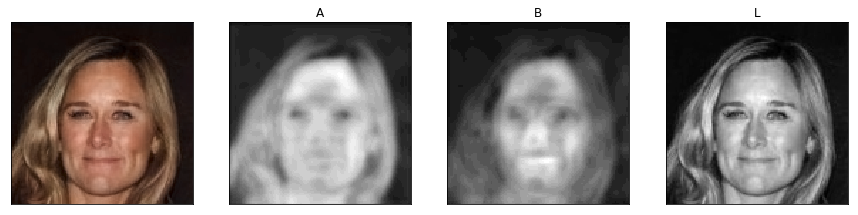

predy 125.40178 151.97333 134.21756 (1, 128, 128, 2)
A: 125.40178 148.26526 132.68774
B: 127.199936 151.97333 135.74734
predy uint8 125 151 133.71539306640625
A uint8 125 148 132.179931640625


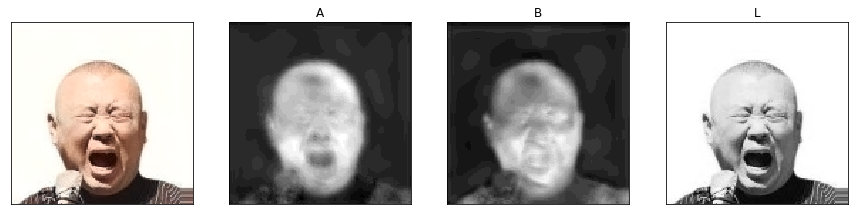

predy 124.69705 157.91231 137.0299 (1, 128, 128, 2)
A: 126.63219 157.91231 135.87341
B: 124.69705 155.72504 138.18642
predy uint8 124 157 136.53219604492188
A uint8 126 157 135.377685546875


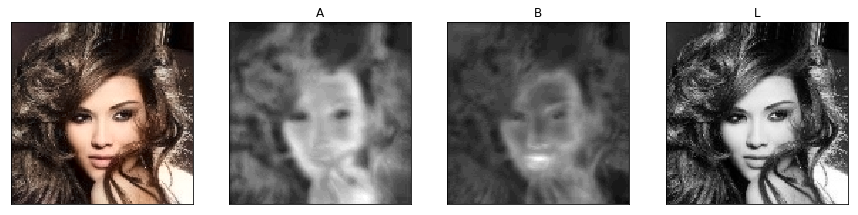

predy 125.34235 169.04828 138.19308 (1, 128, 128, 2)
A: 127.35277 169.04828 137.13947
B: 125.34235 157.06416 139.24673
predy uint8 125 169 137.69415283203125
A uint8 127 169 136.636962890625


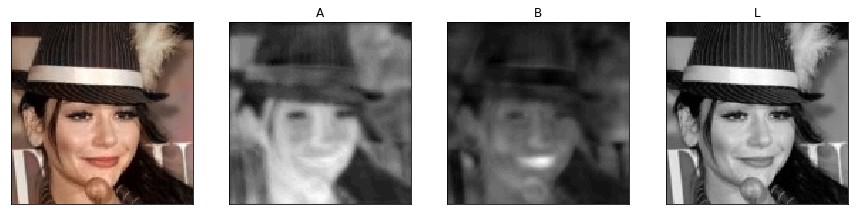

predy 122.75463 169.45903 140.3494 (1, 128, 128, 2)
A: 129.4838 169.45903 139.03734
B: 122.75463 157.17683 141.66147
predy uint8 122 169 139.84664916992188
A uint8 129 169 138.5330810546875


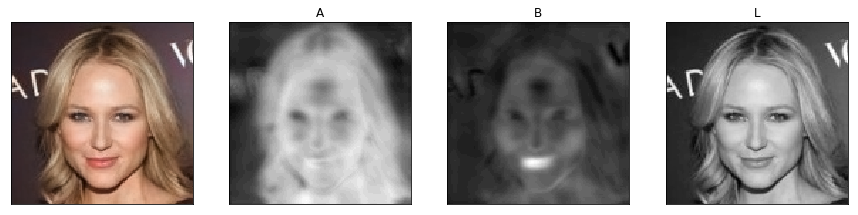

predy 121.80997 163.76776 138.53278 (1, 128, 128, 2)
A: 126.95712 163.76776 137.66547
B: 121.80997 154.39761 139.40009
predy uint8 121 163 138.03475952148438
A uint8 126 163 137.1646728515625


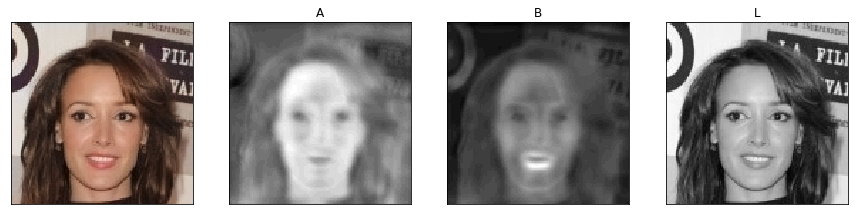

predy 125.00645 162.7026 137.85667 (1, 128, 128, 2)
A: 125.00645 162.7026 136.19876
B: 127.42224 156.52847 139.51462
predy uint8 125 162 137.35955810546875
A uint8 125 162 135.6964111328125


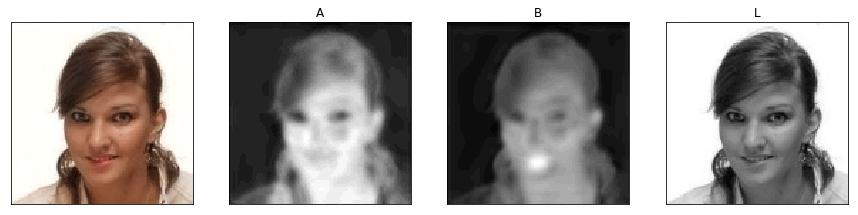

predy 121.3127 155.78156 135.62317 (1, 128, 128, 2)
A: 121.3127 150.74666 133.46777
B: 125.68277 155.78156 137.77856
predy uint8 121 155 135.11965942382812
A uint8 121 150 132.9620361328125


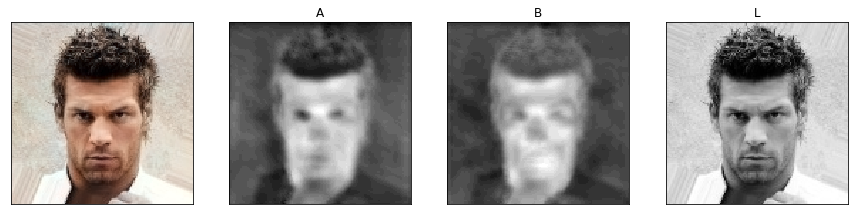

predy 126.227356 155.4705 133.84015 (1, 128, 128, 2)
A: 126.98146 155.4705 133.37126
B: 126.227356 154.73987 134.30905
predy uint8 126 155 133.3363037109375
A uint8 126 155 132.87103271484375


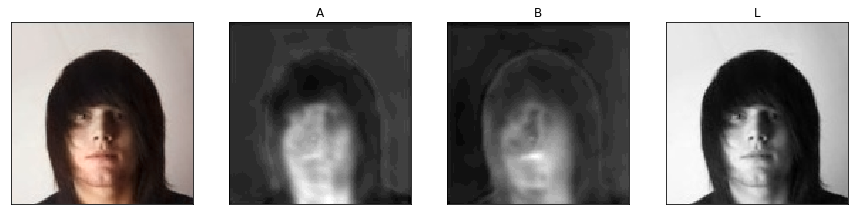

predy 126.1938 163.19025 139.12181 (1, 128, 128, 2)
A: 126.1938 163.19025 137.02844
B: 127.62949 154.5446 141.21518
predy uint8 126 163 138.6201171875
A uint8 126 163 136.524169921875


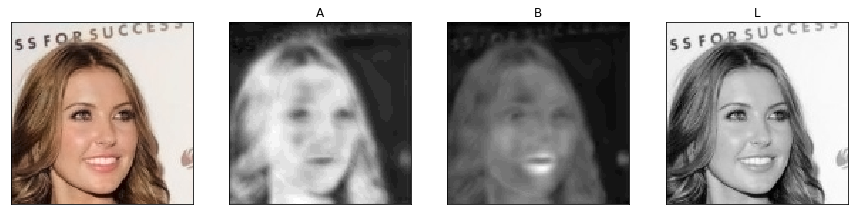

predy 126.72076 154.53477 140.09251 (1, 128, 128, 2)
A: 129.72762 149.83687 137.55334
B: 126.72076 154.53477 142.63165
predy uint8 126 154 139.59390258789062
A uint8 129 149 137.05340576171875


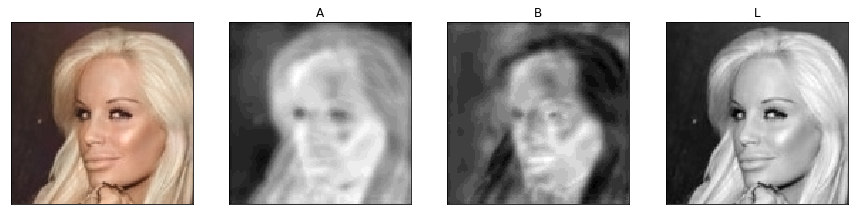

predy 128.89674 166.08215 141.34561 (1, 128, 128, 2)
A: 128.89674 166.08215 138.63528
B: 131.9011 155.76367 144.05594
predy uint8 128 166 140.84716796875
A uint8 128 166 138.1353759765625


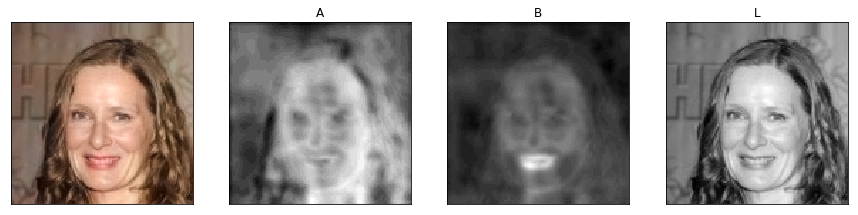

predy 124.38577 160.84009 136.84476 (1, 128, 128, 2)
A: 124.38577 160.84009 136.74118
B: 124.588806 155.57709 136.94833
predy uint8 124 160 136.34539794921875
A uint8 124 160 136.2451171875


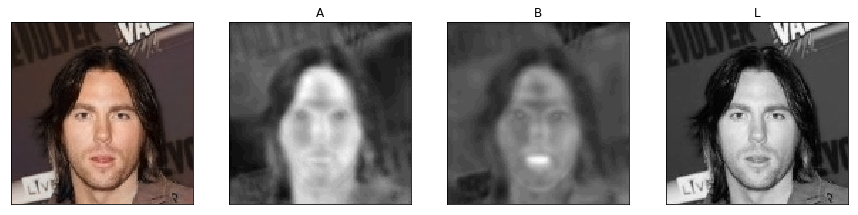

predy 126.1558 165.04178 135.47362 (1, 128, 128, 2)
A: 126.1558 165.04178 135.19193
B: 126.92701 153.98166 135.75534
predy uint8 126 165 134.96633911132812
A uint8 126 165 134.671875


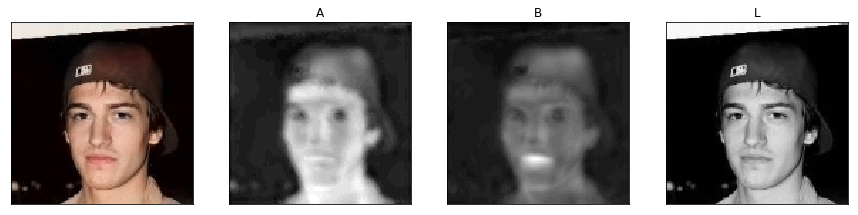

predy 125.895325 158.12428 138.75497 (1, 128, 128, 2)
A: 125.895325 158.12428 137.70361
B: 127.8418 153.72444 139.80634
predy uint8 125 158 138.2564697265625
A uint8 125 158 137.20269775390625


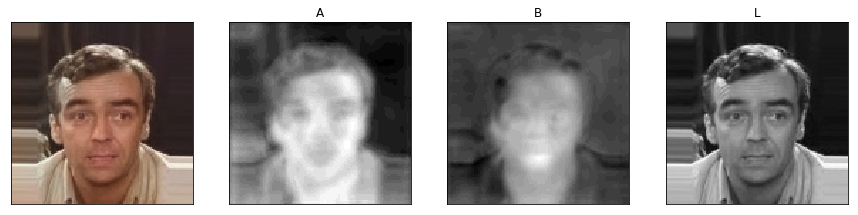

predy 121.51518 158.37021 143.72057 (1, 128, 128, 2)
A: 121.51518 155.66582 140.84195
B: 126.393814 158.37021 146.59918
predy uint8 121 158 143.22305297851562
A uint8 121 155 140.343994140625


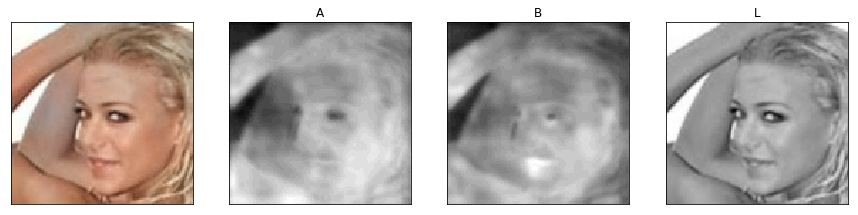

predy 126.172935 156.59627 136.01616 (1, 128, 128, 2)
A: 126.172935 156.59627 135.33984
B: 127.9718 156.49657 136.69247
predy uint8 126 156 135.51513671875
A uint8 126 156 134.8380126953125


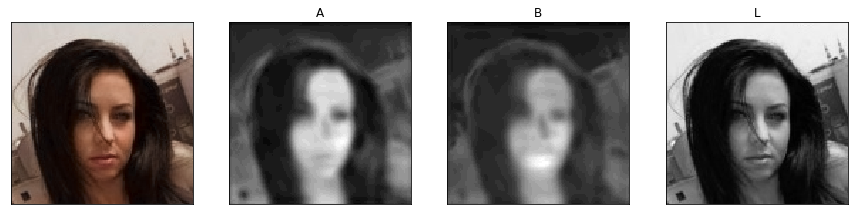

predy 122.64261 148.76994 135.07343 (1, 128, 128, 2)
A: 122.64261 145.50093 134.06378
B: 126.37684 148.76994 136.08307
predy uint8 122 148 134.576416015625
A uint8 122 145 133.56475830078125


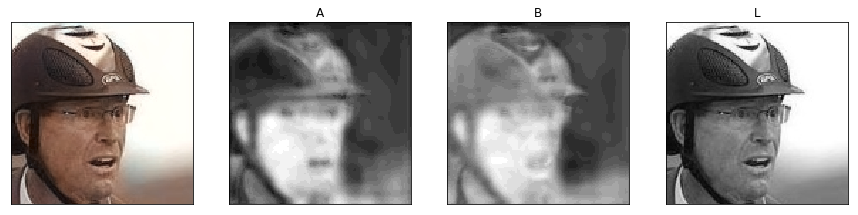

predy 125.62332 153.11282 139.38254 (1, 128, 128, 2)
A: 125.62332 151.59703 137.32207
B: 127.62276 153.11282 141.443
predy uint8 125 153 138.87945556640625
A uint8 125 151 136.818603515625


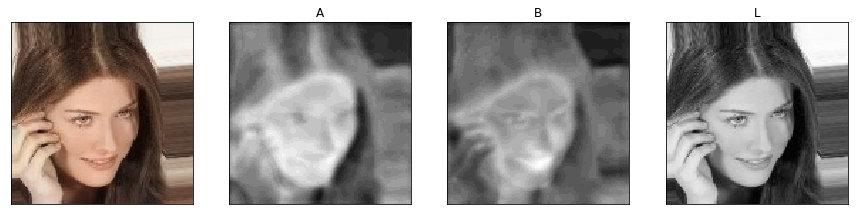

predy 120.96722 166.75743 137.94873 (1, 128, 128, 2)
A: 126.71624 166.75743 137.8025
B: 120.96722 158.67172 138.09497
predy uint8 120 166 137.45022583007812
A uint8 126 166 137.303466796875


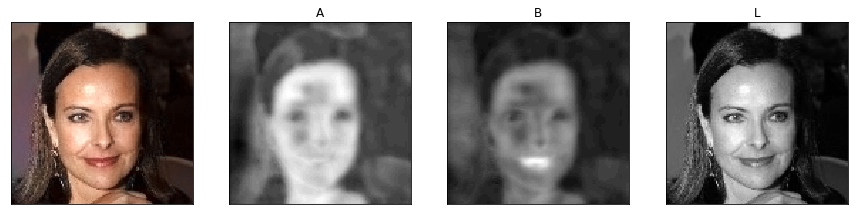

predy 124.94709 155.11143 137.3787 (1, 128, 128, 2)
A: 124.94709 154.80498 136.45963
B: 125.06035 155.11143 138.29776
predy uint8 124 155 136.879150390625
A uint8 124 154 135.962646484375


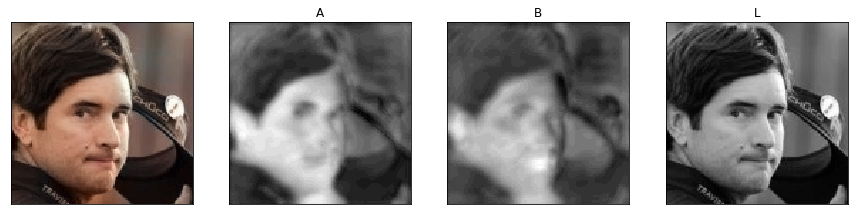

predy 125.25818 164.38939 139.35342 (1, 128, 128, 2)
A: 125.25818 164.38939 137.7525
B: 127.9947 157.27435 140.95435
predy uint8 125 164 138.85159301757812
A uint8 125 164 137.2529296875


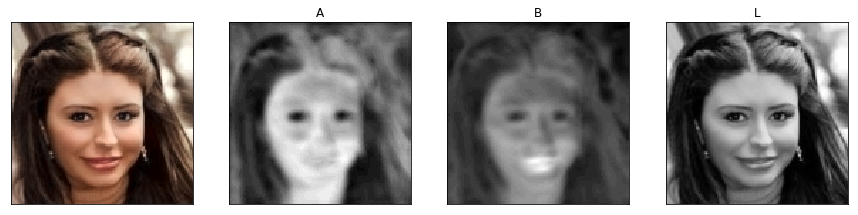

predy 125.90447 157.5428 135.01585 (1, 128, 128, 2)
A: 127.99673 157.5428 134.84926
B: 125.90447 156.36061 135.18246
predy uint8 125 157 134.50558471679688
A uint8 127 157 134.34075927734375


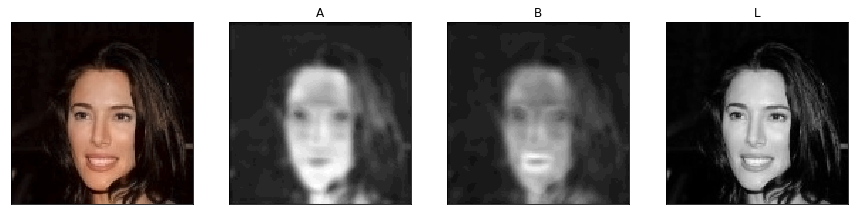

predy 125.654594 158.73082 134.21225 (1, 128, 128, 2)
A: 125.654594 158.73082 133.1243
B: 126.27783 154.79503 135.30017
predy uint8 125 158 133.70974731445312
A uint8 125 158 132.62615966796875


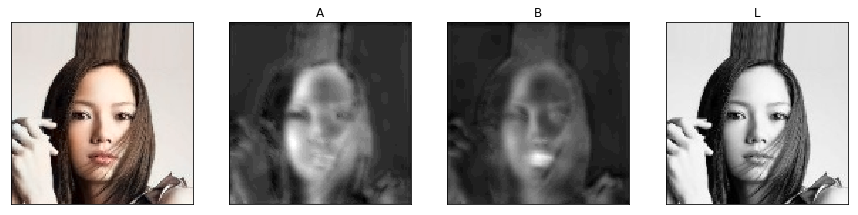

In [45]:
print('countEpochs',countEpochs)
predictions(trainSize+valSize+40, 40)


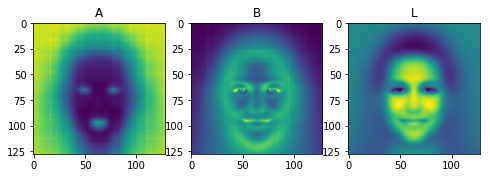

Non-ML baseline - Input value with mean Hue and mean Saturation:


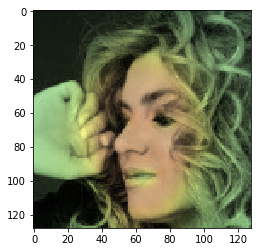

In [37]:
def nonMlBaseline():
    x = training_generator[15][0][0,...,0]
    var, mean = getImagesVarAndMean([dataDir + idx for idx in train_IDs], params['dim'] + (3,))
    y = np.dstack([mean[...,0].astype('uint8'), mean[...,1].astype('uint8'), x.astype('uint8')])

    fig = plt.figure(figsize=(8,8))
    for i in range(1,4):
        fig.add_subplot(1,3,i)
        plt.title(['A','B','L'][i-1])
        plt.imshow(mean[...,i-1])
    plt.show()
    print("Non-ML baseline - Input value with mean Hue and mean Saturation:")
    global rgb, lab
    rgb_save, lab_save = rgb, lab
    rgb, lab = False, False
    showHsv(y)
    rgb, lab = rgb_save, lab_save
nonMlBaseline()

In [44]:
print("testing custom Loss:")
x = Input(shape=(None,))
y = Input(shape=(None,))
loss_func = K.function([x, y], [customLoss(x, y)])
loss_func([[[[1,1], [1,16] ]], [[[1,1], [1,14]]] ])

testing custom Loss:


[array([[ 0.,  0.],
        [ 0., 20.]], dtype=float32)]

In [ ]:
# model.save(f'data/{NAME}.h5')

In [ ]:
# print("OpenCV uses H: 0 - 180, S: 0 - 255, V: 0 - 255")
# batch=55
# print('testing channel ranges:')
# print(training_generator[batch][1][...,0].max(), training_generator[batch][1][...,0].min())
# print(training_generator[batch][1].shape)
# h = np.minimum(training_generator[batch][1][0,..., 0 ] + 0, 180).astype('uint8') 
# s = np.minimum(training_generator[batch][1][0,..., 1 ] + 0, 255).astype('uint8')
# v = training_generator[batch][0][0,...].astype('uint8')
# y = np.dstack([h , s, v ] )
# showHsv(y )
# print(h.min(), h.max())
# plt.imshow(h)

# show filters

# x1w = model.get_weights()[0][:,:,0,:]
# for i in range(1,26):
#   plt.subplot(5,5,i)
#   plt.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
# plt.show()

In [39]:
def demo(imgpath):
    img = cv2.imread(imgpath)
    img = cv2.resize(img, (128,128))
    cv2.imwrite("./tmp.jpg", img)
    predictFromImage("./tmp.jpg", True)
    try:
        os.remove("./tmp.jpg")
    except OSError:
        pass

In [19]:
testSplit = int(trainSize + valSize)
test_IDs = data_IDs[testSplit:]
print('test len', len(test_IDs))
test_generator = DataGenerator(test_IDs, **params)
test_eval = model.evaluate_generator(test_generator)

test len 36469


In [38]:
_ = [print (f'{x[0]}: {x[1]}') for x in zip(model.metrics_names, test_eval)]

loss: 103.67700061011043
mean_absolute_error: 6.614184391299709
mean_squared_error: 103.67700083450438


predy 127.76628 155.02452 136.76706 (1, 128, 128, 2)
A: 127.76628 150.37823 135.94928
B: 127.90308 155.02452 137.58484
predy uint8 127 155 136.26373291015625
A uint8 127 150 135.45159912109375


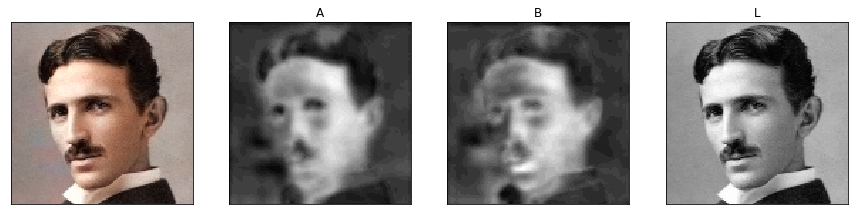

In [43]:
demo('demo.jpg')